<a href="https://colab.research.google.com/github/iuliatodoran/Excursii_WebSemantic/blob/main/Text_Reader_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enviroment setup

In [ ]:
!pip -q install ultralytics==8.3.34 easyocr==1.7.1 gTTS==2.5.3 opencv-python-headless==4.10.0.84
import sys, os, cv2, torch, numpy as np
import platform
from gtts import gTTS
import easyocr

print("All done!")

All done!


In [ ]:
import os, cv2, numpy as np

COLOR_PATH = "/content/challenge_color_848x480.mp4"
DEPTH_PATH = "/content/challenge_depth_848x480.mp4"

assert os.path.exists(COLOR_PATH), f"File not found: {COLOR_PATH}"
assert os.path.exists(DEPTH_PATH), f"File not found: {DEPTH_PATH}"

print("Files uploaded!\n")

def inspect_video(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {path}")
    info = {
        "path": path,
        "fps": cap.get(cv2.CAP_PROP_FPS),
        "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        "frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    }
    ok, frame = cap.read()
    info["first_frame_ok"] = bool(ok)
    if ok:
        h, w, _ = frame.shape
        center_pixel = frame[h//2, w//2].tolist()
        info["center_pixel_bgr"] = center_pixel
    cap.release()
    return info

color_info = inspect_video(COLOR_PATH)
depth_info = inspect_video(DEPTH_PATH)

print("Color video info:")
for k, v in color_info.items():
    print(f"  {k}: {v}")

print("\nDepth video info:")
for k, v in depth_info.items():
    print(f"  {k}: {v}")

same_dims = (color_info["width"], color_info["height"]) == (depth_info["width"], depth_info["height"])
print(f"\nResolution match: {same_dims}")
print("Videos are ready for processing")

Files uploaded!

Color video info:
  path: /content/challenge_color_848x480.mp4
  fps: 30.0
  width: 848
  height: 480
  frame_count: 13402
  first_frame_ok: True
  center_pixel_bgr: [176, 172, 196]

Depth video info:
  path: /content/challenge_depth_848x480.mp4
  fps: 30.0
  width: 848
  height: 480
  frame_count: 13209
  first_frame_ok: True
  center_pixel_bgr: [9, 9, 9]

Resolution match: True
Videos are ready for processing.


Auto OCR on video + speak results + save annotated MP4 and CSV

In [ ]:
import cv2, numpy as np, os, csv, time, torch, easyocr
from gtts import gTTS

COLOR_PATH = "/content/challenge_color_848x480.mp4"
DEPTH_PATH = "/content/challenge_depth_848x480.mp4"

FRAME_STRIDE = 15
RESIZE_FOR_OCR = 0.5
OCR_MIN_CONF = 0.60
READ_COOLDOWN_SEC = 8.0
MERGE_IOU = 0.3
LANGS = ['ro','en']
MAX_FRAMES_TO_PROCESS = 1200
MAX_RUNTIME_SEC = 180
SPEAK_AUDIO = False

def speak_text(text, out_dir="/content/tts", lang="ro"):
    os.makedirs(out_dir, exist_ok=True)
    name = str(int(time.time()*1000)) + ".mp3"
    path = os.path.join(out_dir, name)
    try:
        gTTS(text=text, lang=lang).save(path)
        return path
    except Exception:
        return ""

print("Opening video...")
cap = cv2.VideoCapture(COLOR_PATH)
assert cap.isOpened(), f"Cannot open: {COLOR_PATH}"

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video: {W}x{H} @ {fps:.1f} fps | frames={total}")
print("Initializing EasyOCR (CPU)...")
reader = easyocr.Reader(LANGS, gpu=False)
print("OCR ready.")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "/content/auto_ocr_annotated_fast.mp4"
writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

csv_path = "/content/auto_ocr_log_fast.csv"
csv_f = open(csv_path, "w", newline="", encoding="utf-8")
csv_w = csv.writer(csv_f)
csv_w.writerow(["frame","time_s","text","conf","x1","y1","x2","y2"])

def iou(a,b):
    ax1,ay1,ax2,ay2 = a; bx1,by1,bx2,by2 = b
    ix1,iy1 = max(ax1,bx1), max(ay1,by1)
    ix2,iy2 = min(ax2,bx2), min(ay2,by2)
    inter = max(0, ix2-ix1) * max(0, iy2-iy1)
    ua = max(0,ax2-ax1)*max(0,ay2-ay1) + max(0,bx2-bx1)*max(0,by2-by1) - inter + 1e-6
    return inter/ua

def normalize_text(t):
    t = " ".join(t.strip().split())
    return t

recent_reads = []
def should_read(t, cooldown=READ_COOLDOWN_SEC):
    now = time.time()
    while recent_reads and now - recent_reads[0][0] > cooldown:
        recent_reads.pop(0)
    for ts, tt in recent_reads:
        if tt == t:
            return False
    recent_reads.append((now, t))
    return True

start_t = time.time()
frame_idx = 0
proc_frames = 0
last_progress_print = start_t
avg_frame_time = None

while True:
    ok, frm = cap.read()
    if not ok:
        break

    if frame_idx % FRAME_STRIDE != 0:
        writer.write(frm)
        frame_idx += 1
        continue

    tick = time.time()
    rgb = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)

    if RESIZE_FOR_OCR != 1.0:
        small = cv2.resize(rgb, (int(W*RESIZE_FOR_OCR), int(H*RESIZE_FOR_OCR)), interpolation=cv2.INTER_LINEAR)
        sx = W / small.shape[1]; sy = H / small.shape[0]
        ocr_in = small
    else:
        sx = sy = 1.0
        ocr_in = rgb

    ocr_res = reader.readtext(ocr_in, detail=1, paragraph=False)
    boxes = []
    for (bbox, text, conf) in ocr_res:
        if conf < OCR_MIN_CONF:
            continue
        xs = [int(p[0]) for p in bbox]
        ys = [int(p[1]) for p in bbox]
        x1,y1,x2,y2 = min(xs), min(ys), max(xs), max(ys)
        x1 = int(x1 * sx); y1 = int(y1 * sy)
        x2 = int(x2 * sx); y2 = int(y2 * sy)
        boxes.append([x1,y1,x2,y2, normalize_text(text), float(conf)])

    merged = []
    for b in boxes:
        merged_flag = False
        for m in merged:
            if m[4] == b[4] and iou(m[:4], b[:4]) > MERGE_IOU:
                m[0] = min(m[0], b[0]); m[1] = min(m[1], b[1])
                m[2] = max(m[2], b[2]); m[3] = max(m[3], b[3])
                m[5] = max(m[5], b[5])
                merged_flag = True
                break
        if not merged_flag:
            merged.append(b)

    draw = frm.copy()
    t_secs = frame_idx / fps
    for (x1,y1,x2,y2, textn, conf) in merged:
        cv2.rectangle(draw, (x1,y1), (x2,y2), (0,200,0), 2)
        cv2.putText(draw, f"{textn} ({conf:.2f})", (x1, max(15, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,180,0), 2, cv2.LINE_AA)

        if SPEAK_AUDIO and should_read(textn):
            _ = speak_text(textn)

        csv_w.writerow([frame_idx, f"{t_secs:.2f}", textn, f"{conf:.3f}", x1,y1,x2,y2])

    writer.write(draw)
    proc_frames += 1

    tock = time.time()
    dt = tock - tick
    avg_frame_time = dt if avg_frame_time is None else (0.9*avg_frame_time + 0.1*dt)

    now = time.time()
    if now - last_progress_print >= 5:
        est_fps = (1.0 / avg_frame_time) if avg_frame_time and avg_frame_time > 0 else 0.0
        print(f"Progress: frame {frame_idx}/{total} | processed={proc_frames} | ~{est_fps:.2f} fps (proc) | elapsed={now-start_t:.1f}s")
        last_progress_print = now

    if proc_frames >= MAX_FRAMES_TO_PROCESS:
        print(f"Stopping (processed cap {MAX_FRAMES_TO_PROCESS}).")
        break
    if (now - start_t) >= MAX_RUNTIME_SEC:
        print(f"Stopping (runtime cap {MAX_RUNTIME_SEC}s).")
        break

    frame_idx += 1

cap.release()
writer.release()
csv_f.close()

print("\nDone (fast debug).")
print("Annotated video:", out_path)
print("CSV log:", csv_path)


Opening video...
Video: 848x480 @ 30.0 fps | frames=13402
Initializing EasyOCR (CPU)...
OCR ready.
Progress: frame 45/13402 | processed=4 | ~0.69 fps (proc) | elapsed=6.2s
Progress: frame 90/13402 | processed=7 | ~0.65 fps (proc) | elapsed=11.9s
Progress: frame 150/13402 | processed=11 | ~0.66 fps (proc) | elapsed=18.3s
Progress: frame 195/13402 | processed=14 | ~0.63 fps (proc) | elapsed=23.9s
Progress: frame 255/13402 | processed=18 | ~0.65 fps (proc) | elapsed=30.1s
Progress: frame 300/13402 | processed=21 | ~0.62 fps (proc) | elapsed=35.8s
Progress: frame 360/13402 | processed=25 | ~0.64 fps (proc) | elapsed=42.3s
Progress: frame 405/13402 | processed=28 | ~0.62 fps (proc) | elapsed=47.7s
Progress: frame 450/13402 | processed=31 | ~0.63 fps (proc) | elapsed=52.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Progress: frame 510/13402 | processed=35 | ~0.62 fps (proc) | elapsed=59.7s
Progress: frame 555/13402 | processed=38 | ~0.61 fps (proc) | elapsed=65.2s
Progress: frame 615/13402 | processed=42 | ~0.62 fps (proc) | elapsed=71.8s
Progress: frame 660/13402 | processed=45 | ~0.61 fps (proc) | elapsed=77.4s
Progress: frame 720/13402 | processed=49 | ~0.63 fps (proc) | elapsed=83.8s
Progress: frame 765/13402 | processed=52 | ~0.62 fps (proc) | elapsed=89.5s
Progress: frame 825/13402 | processed=56 | ~0.63 fps (proc) | elapsed=95.9s
Progress: frame 870/13402 | processed=59 | ~0.61 fps (proc) | elapsed=101.6s
Progress: frame 930/13402 | processed=63 | ~0.64 fps (proc) | elapsed=108.0s
Progress: frame 975/13402 | processed=66 | ~0.61 fps (proc) | elapsed=113.7s
Progress: frame 1035/13402 | processed=70 | ~0.64 fps (proc) | elapsed=120.0s
Progress: frame 1080/13402 | processed=73 | ~0.62 fps (proc) | elapsed=125.7s
Progress: frame 1140/13402 | processed=77 | ~0.63 fps (proc) | elapsed=132.3s
Pro

In [ ]:
import os, pandas as pd
from IPython.display import HTML
from google.colab import files

src_mp4_fast = "/content/auto_ocr_annotated_fast.mp4"
src_csv_fast = "/content/auto_ocr_log_fast.csv"

assert os.path.exists(src_mp4_fast), f"Missing video: {src_mp4_fast}"
assert os.path.exists(src_csv_fast), f"Missing CSV: {src_csv_fast}"

print("Source sizes:")
print("  video:", os.path.getsize(src_mp4_fast), "bytes")
print("  csv  :", os.path.getsize(src_csv_fast), "bytes")

out_mp4_h264 = "/content/auto_ocr_annotated_fast_h264.mp4"
!ffmpeg -y -i "{src_mp4_fast}" -c:v libx264 -pix_fmt yuv420p -movflags +faststart -preset veryfast -crf 23 -c:a copy "{out_mp4_h264}"

print("Re-encoded video:", out_mp4_h264, "| size:", os.path.getsize(out_mp4_h264), "bytes")

HTML(f'''
<video width="900" controls>
  <source src="{out_mp4_h264}" type="video/mp4">
  Your browser does not support the video tag.
</video>
''')


Source sizes:
  video: 44770063 bytes
  csv  : 824 bytes
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --en

In [ ]:
from google.colab import files
from google.colab import drive
import shutil, os

h264_path = "/content/auto_ocr_annotated_fast_h264.mp4"
csv_path  = "/content/auto_ocr_log_fast.csv"

assert os.path.exists(h264_path)
assert os.path.exists(csv_path)

print("Trying direct download...")
try:
    files.download(h264_path)
    files.download(csv_path)
except Exception as e:
    print("Direct download failed:", e)

print("\nMounting Drive and copying files there for manual download from Drive UI...")
drive.mount('/content/drive', force_remount=True)
drive_folder = "/content/drive/MyDrive/colab_outputs"
os.makedirs(drive_folder, exist_ok=True)

dst_video = os.path.join(drive_folder, os.path.basename(h264_path))
dst_csv   = os.path.join(drive_folder, os.path.basename(csv_path))

shutil.copy2(h264_path, dst_video)
shutil.copy2(csv_path, dst_csv)

print("Copied to Drive:")
print("  ", dst_video)
print("  ", dst_csv)
print("Open Google Drive > My Drive > colab_outputs to fetch them.")

Trying direct download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Mounting Drive and copying files there for manual download from Drive UI...
Mounted at /content/drive
Copied to Drive:
   /content/drive/MyDrive/colab_outputs/auto_ocr_annotated_fast_h264.mp4
   /content/drive/MyDrive/colab_outputs/auto_ocr_log_fast.csv
Open Google Drive > My Drive > colab_outputs to fetch them.


In [ ]:
import pandas as pd

csv_path  = "/content/auto_ocr_log_fast.csv"
df = pd.read_csv(csv_path)
print("Rows:", len(df))
print("\nHead:")
display(df.head(10))

print("\nDistinct texts (first 25):")
print(sorted(df["text"].astype(str).str.slice(0,80).unique())[:25])

Rows: 19

Head:


,frame,time_s,text,conf,x1,y1,x2,y2
0,1245,41.5,direct,1.000,434,278,494,302
1,1260,42.0,nasina,0.887,422,270,490,298
2,1260,42.0,direct,0.976,426,294,490,326
3,1275,42.5,Intra cu,0.866,450,218,526,246
4,1275,42.5,masina,0.991,450,242,530,274
5,1275,42.5,direct,1.000,448,268,530,308
6,1275,42.5,la raft.,0.726,450,302,526,334
7,1290,43.0,Intră cu,0.949,510,222,606,258
8,1290,43.0,masina,0.950,506,254,606,294
9,1290,43.0,direct,1.000,506,290,602,330



Distinct texts (first 25):
['DRIVE', 'Intra cu', 'Intră cu', 'direc', 'direct', 'la raft.', 'masi', 'masina', 'nasina']




---





---




In [ ]:
!unzip -o /content/archive.zip -d /content/kaggle_east > /dev/null

In [ ]:
import shutil, glob, os

matches = glob.glob("/content/kaggle_east/**/*.pb", recursive=True)
assert matches, "No .pb file found in archive.zip"
src_pb = matches[0]

EAST_PATH = "/content/frozen_east_text_detection.pb"
shutil.copy2(src_pb, EAST_PATH)
print("EAST model copied to:", EAST_PATH, "| size:", os.path.getsize(EAST_PATH))

EAST model copied to: /content/frozen_east_text_detection.pb | size: 96662756


In [ ]:
import cv2
net_east = cv2.dnn.readNet("/content/frozen_east_text_detection.pb")
print("Loaded EAST into OpenCV DNN.")

Loaded EAST into OpenCV DNN.


In [ ]:
import os, time, csv, math, glob
import cv2
import numpy as np
import torch, easyocr
from gtts import gTTS

COLOR_PATH = "/content/challenge_color_848x480.mp4"
DEPTH_PATH = "/content/challenge_depth_848x480.mp4"

FRAME_STRIDE        = 10
MAX_SECONDS_RUNTIME = 180
MAX_FRAMES_PROCESS  = 1500
RESIZE_FOR_DETECT   = 0.75
OCR_MIN_CONF        = 0.55
SPEAK_AUDIO         = False
READ_COOLDOWN_SEC   = 8.0
TTS_LANG            = "ro"

EAST_INPUT_W        = 320
EAST_INPUT_H        = 320
EAST_CONF_THRESH    = 0.50
EAST_NMS_THRESH     = 0.20
ROI_GROW_PIX        = 4


def speak_text(text, out_dir="/content/tts", lang=TTS_LANG):
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, f"{int(time.time()*1000)}.mp3")
    try:
        gTTS(text=text, lang=lang).save(path)
        return path
    except Exception as e:
        print("TTS error:", e)
        return ""

def normalize_text(t: str) -> str:
    t = t.replace("\n"," ")
    t = " ".join(t.split())
    return t

recent_spoken = []
def should_speak(text, cooldown=READ_COOLDOWN_SEC):
    now = time.time()
    while recent_spoken and now - recent_spoken[0][0] > cooldown:
        recent_spoken.pop(0)
    for ts, t in recent_spoken:
        if t == text:
            return False
    recent_spoken.append((now, text))
    return True

def decode_east(scores, geometry, scoreThresh):
    numRows, numCols = scores.shape[2:4]
    rects = []
    confidences = []
    for y in range(numRows):
        scoresData = scores[0,0,y]
        x0 = geometry[0,0,y]; x1 = geometry[0,1,y]; x2 = geometry[0,2,y]; x3 = geometry[0,3,y]
        anglesData = geometry[0,4,y]
        for x in range(numCols):
            score = float(scoresData[x])
            if score < scoreThresh:
                continue
            offsetX, offsetY = x*4.0, y*4.0
            angle = float(anglesData[x])
            cosA = np.cos(angle); sinA = np.sin(angle)
            h = float(x0[x] + x2[x]); w = float(x1[x] + x3[x])
            endX = int(offsetX + (cosA * x1[x]) + (sinA * x2[x]))
            endY = int(offsetY - (sinA * x1[x]) + (cosA * x2[x]))
            startX = int(endX - w); startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(score)
    return rects, confidences

use_gpu = torch.cuda.is_available()
print("Initializing EasyOCR... GPU:", use_gpu)
reader = easyocr.Reader(['ro','en'], gpu=use_gpu)
print("OCR ready.")

cap = cv2.VideoCapture(COLOR_PATH)
assert cap.isOpened(), f"Cannot open {COLOR_PATH}"
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video: {W}x{H} @ {fps:.1f} | frames={total}")

depth_cap = cv2.VideoCapture(DEPTH_PATH)
use_depth = depth_cap.isOpened()
p20, p80 = (20, 80)

if use_depth:
    vals = []
    pos = depth_cap.get(cv2.CAP_PROP_POS_FRAMES)
    depth_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for _ in range(60):
        ok, fr = depth_cap.read()
        if not ok: break
        g = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        vals.extend(g.flatten().tolist())
    depth_cap.set(cv2.CAP_PROP_POS_FRAMES, pos)
    if vals:
        p20, p80 = np.percentile(vals, 20), np.percentile(vals, 80)
        print(f"Depth percentiles p20={p20:.1f}, p80={p80:.1f}")

def tag_depth(val):
    if val <= p20: return "Near"
    if val >= p80: return "Far"
    return "Medium"

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_mp4 = "/content/auto_ocr_annotated_fastROI.mp4"
writer = cv2.VideoWriter(out_mp4, fourcc, fps, (W, H))

csv_path = "/content/auto_ocr_log_fastROI.csv"
csv_f = open(csv_path, "w", newline="", encoding="utf-8")
csv_w = csv.writer(csv_f)
csv_w.writerow(["frame","time_s","text","conf","x1","y1","x2","y2","depth","depth_tag","mp3"])

start = time.time()
processed = 0
frame_idx = 0
last_print = start

while True:
    ok, frame = cap.read()
    if not ok:
        break
    if frame_idx % FRAME_STRIDE != 0:
        writer.write(frame)
        frame_idx += 1
        continue

    det_img = frame
    if RESIZE_FOR_DETECT != 1.0:
        det_img = cv2.resize(frame, (int(W*RESIZE_FOR_DETECT), int(H*RESIZE_FOR_DETECT)))
    (H0, W0) = det_img.shape[:2]

    blob = cv2.dnn.blobFromImage(det_img, 1.0, (EAST_INPUT_W, EAST_INPUT_H),
                                 (123.68,116.78,103.94), swapRB=True, crop=False)
    net_east.setInput(blob)
    scores, geometry = net_east.forward(["feature_fusion/Conv_7/Sigmoid",
                                         "feature_fusion/concat_3"])

    rects, confidences = decode_east(scores, geometry, EAST_CONF_THRESH)
    rW = W0 / float(EAST_INPUT_W)
    rH = H0 / float(EAST_INPUT_H)
    rois = []
    for (sx1, sy1, sx2, sy2), sc in zip(rects, confidences):
        x1 = int(max(0, sx1 * rW) - ROI_GROW_PIX)
        y1 = int(max(0, sy1 * rH) - ROI_GROW_PIX)
        x2 = int(min(W0-1, sx2 * rW) + ROI_GROW_PIX)
        y2 = int(min(H0-1, sy2 * rH) + ROI_GROW_PIX)
        if x2-x1 >= 15 and y2-y1 >= 12:
            rois.append((x1,y1,x2,y2, sc))

    scale_x = W / float(W0)
    scale_y = H / float(H0)
    rois_full = []
    for (x1,y1,x2,y2, sc) in rois:
        X1 = int(np.clip(x1 * scale_x, 0, W-1))
        Y1 = int(np.clip(y1 * scale_y, 0, H-1))
        X2 = int(np.clip(x2 * scale_x, 0, W-1))
        Y2 = int(np.clip(y2 * scale_y, 0, H-1))
        rois_full.append((X1,Y1,X2,Y2, sc))

    draw = frame.copy()
    depth_gray = None
    if use_depth:
        okd, dfrm = depth_cap.read()
        if okd:
            depth_gray = cv2.cvtColor(dfrm, cv2.COLOR_BGR2GRAY)

    for (X1,Y1,X2,Y2, sc) in rois_full:
        crop = frame[Y1:Y2, X1:X2]
        if crop.size == 0:
            continue
        rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        ocr_res = reader.readtext(rgb, detail=1, paragraph=False)
        for (bbox, text, conf) in ocr_res:
            if conf < OCR_MIN_CONF:
                continue
            t = normalize_text(text)
            if not t:
                continue

            dval, dtag = -1, ""
            cx, cy = (X1+X2)//2, (Y1+Y2)//2
            if depth_gray is not None:
                dval = int(depth_gray[np.clip(cy,0,H-1), np.clip(cx,0,W-1)])
                dtag = tag_depth(dval)

            cv2.rectangle(draw, (X1, Y1), (X2, Y2), (0,200,0), 2)
            label = f"{t} ({conf:.2f})" + (f" [{dtag}]" if dtag else "")
            ty = Y1 - 6 if Y1 - 6 > 10 else Y1 + 16
            cv2.putText(draw, label, (X1, ty), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,180,0), 2, cv2.LINE_AA)

            mp3 = ""
            if SPEAK_AUDIO and should_speak(t):
                mp3 = speak_text(t)

            csv_w.writerow([frame_idx, f"{frame_idx/fps:.2f}", t, f"{conf:.3f}", X1,Y1,X2,Y2, dval, dtag, mp3])

    writer.write(draw)
    processed += 1

    now = time.time()
    if now - last_print >= 5:
        print(f"Progress: frame {frame_idx}/{total} | processed={processed} | elapsed={now-start:.1f}s | ROIs={len(rois_full)}")
        last_print = now
    if processed >= MAX_FRAMES_PROCESS:
        print("Stopping due to MAX_FRAMES_PROCESS.")
        break
    if now - start >= MAX_SECONDS_RUNTIME:
        print("Stopping due to MAX_SECONDS_RUNTIME")
        break

    frame_idx += 1

cap.release()
if depth_cap: depth_cap.release()
writer.release()
csv_f.close()

print("\nDone (EAST + OCR on ROIs).")
print("Annotated video:", out_mp4)
print("CSV:", csv_path)
print("If needed, re-encode for preview:")
print("!ffmpeg -y -i /content/auto_ocr_annotated_fastROI.mp4 -c:v libx264 -pix_fmt yuv420p -movflags +faststart /content/auto_ocr_annotated_fastROI_h264.mp4")

Initializing EasyOCR... GPU: False
OCR ready.
Video: 848x480 @ 30.0 | frames=13402
Depth percentiles p20=5.0, p80=13.0
Progress: frame 70/13402 | processed=8 | elapsed=5.6s | ROIs=0
Progress: frame 190/13402 | processed=20 | elapsed=10.8s | ROIs=2
Progress: frame 230/13402 | processed=24 | elapsed=18.6s | ROIs=5
Progress: frame 290/13402 | processed=30 | elapsed=23.7s | ROIs=0


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Progress: frame 340/13402 | processed=35 | elapsed=29.4s | ROIs=4
Progress: frame 370/13402 | processed=38 | elapsed=35.0s | ROIs=10
Progress: frame 430/13402 | processed=44 | elapsed=41.7s | ROIs=11
Progress: frame 490/13402 | processed=50 | elapsed=47.2s | ROIs=5
Progress: frame 510/13402 | processed=52 | elapsed=52.9s | ROIs=12
Progress: frame 530/13402 | processed=54 | elapsed=61.4s | ROIs=21
Progress: frame 550/13402 | processed=56 | elapsed=68.6s | ROIs=22
Progress: frame 620/13402 | processed=63 | elapsed=73.8s | ROIs=0
Progress: frame 690/13402 | processed=70 | elapsed=79.2s | ROIs=0
Progress: frame 820/13402 | processed=83 | elapsed=84.3s | ROIs=0
Progress: frame 900/13402 | processed=91 | elapsed=89.8s | ROIs=8
Progress: frame 920/13402 | processed=93 | elapsed=95.0s | ROIs=4
Progress: frame 1020/13402 | processed=103 | elapsed=100.9s | ROIs=6
Progress: frame 1080/13402 | processed=109 | elapsed=106.2s | ROIs=7
Progress: frame 1130/13402 | processed=114 | elapsed=111.9s | ROI

In [ ]:
from IPython.display import HTML
from google.colab import files
import os, time

src_mp4 = "/content/auto_ocr_annotated_fastROI.mp4"
src_csv = "/content/auto_ocr_log_fastROI.csv"
assert os.path.exists(src_mp4) and os.path.exists(src_csv), "Missing output files from previous cell."

out_h264 = "/content/auto_ocr_annotated_fastROI_h264.mp4"
!ffmpeg -y -i "{src_mp4}" -c:v libx264 -pix_fmt yuv420p -movflags +faststart -preset veryfast -crf 23 -c:a copy "{out_h264}"

print("Sizes (bytes):",
      "\n  MP4:", os.path.getsize(src_mp4),
      "\n  H264:", os.path.getsize(out_h264),
      "\n  CSV:", os.path.getsize(src_csv))

display(HTML(f'''
<video width="900" controls>
  <source src="{out_h264}" type="video/mp4">
</video>
'''))

files.download(out_h264)
files.download(src_csv)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



In [ ]:
import os, cv2, math

COLOR_PATH = "/content/challenge_color_848x480.mp4"
assert os.path.exists(COLOR_PATH), f"Missing: {COLOR_PATH}"

def load_frame_at_time(video_path, t_seconds):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    frame_idx = int(round(t_seconds * fps))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Could not read frame at t={t_seconds}s (idx={frame_idx}).")
    return frame, fps, frame_idx

print("OK: helper ready")

OK: helper ready.


In [ ]:
T_SECONDS = 41

frame_bgr, fps, idx = load_frame_at_time(COLOR_PATH, T_SECONDS)
print(f"Got frame at t={T_SECONDS}s -> index={idx}, shape={frame_bgr.shape}")

raw_path = "/content/oneframe_raw.jpg"
cv2.imwrite(raw_path, frame_bgr)
print("Saved raw frame to:", raw_path)

Got frame at t=41.0s -> index=1230, shape=(480, 848, 3)
Saved raw frame to: /content/oneframe_raw.jpg


EasyOCR ready. GPU: False

OCR results (bbox, text, conf):
00 | 'orive IM ' | conf=0.360
01 | 'Intra cu' | conf=0.896
02 | 'masina' | conf=0.951
03 | 'direct' | conf=1.000
04 | 'la raft.' | conf=0.724

Saved annotated frame to: /content/oneframe_ocr.jpg


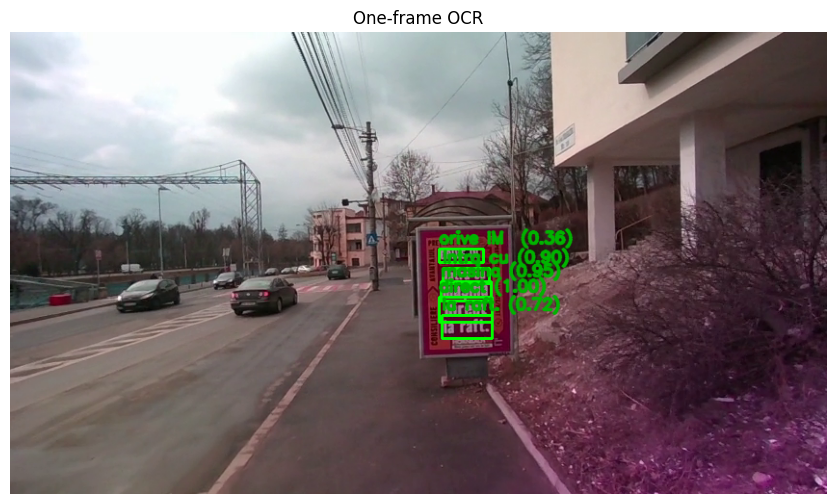


Candidate text to speak:
 Intra cu masina direct la raft.


In [ ]:
!pip -q install easyocr==1.7.1 gTTS==2.5.3 opencv-python-headless==4.10.0.84
import torch, easyocr, numpy as np, matplotlib.pyplot as plt

use_gpu = torch.cuda.is_available()
reader = easyocr.Reader(['ro','en'], gpu=use_gpu)
print("EasyOCR ready. GPU:", use_gpu)

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
results = reader.readtext(frame_rgb, detail=1, paragraph=False)

print("\nOCR results (bbox, text, conf):")
texts = []
for i, (bbox, text, conf) in enumerate(results):
    print(f"{i:02d} | '{text}' | conf={conf:.3f}")
    if conf >= 0.55 and text.strip():
        texts.append(text.strip())

vis = frame_rgb.copy()
for (bbox, text, conf) in results:
    xs = [int(p[0]) for p in bbox]
    ys = [int(p[1]) for p in bbox]
    x1, y1, x2, y2 = min(xs), min(ys), max(xs), max(ys)
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    lab = f"{text} ({conf:.2f})"
    ty = y1 - 6 if y1 - 6 > 10 else y1 + 15
    cv2.putText(vis, lab, (x1, ty), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,180,0), 2, cv2.LINE_AA)

ann_path = "/content/oneframe_ocr.jpg"
cv2.imwrite(ann_path, cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))
print("\nsaved annotated frame to:", ann_path)

plt.figure(figsize=(12,6)); plt.imshow(vis); plt.title("One-frame OCR"); plt.axis("off"); plt.show()

spoken_text = " ".join(" ".join(t.split()) for t in texts)
print("\ntext to speak:\n", spoken_text)

In [ ]:
#TTS for the one-frame OCR result

from gtts import gTTS
from IPython.display import Audio, display
import time, os

def speak_text(text, out_dir="/content/tts", lang="ro", preview=True):
    os.makedirs(out_dir, exist_ok=True)
    if not text.strip():
        print("No text to speak.")
        return ""
    fname = f"{int(time.time()*1000)}_oneframe.mp3"
    mp3_path = os.path.join(out_dir, fname)
    tts = gTTS(text=text, lang=lang)
    tts.save(mp3_path)
    print("Saved MP3:", mp3_path)
    if preview:
        display(Audio(mp3_path, autoplay=False))
    return mp3_path

_ = speak_text(spoken_text if 'spoken_text' in globals() else "", lang="ro", preview=True)

Saved MP3: /content/tts/1761951702012_oneframe.mp3




---





---



In [ ]:
import cv2, numpy as np, math, os, torch, easyocr

COLOR_PATH = "/content/challenge_color_848x480.mp4"
DEPTH_PATH = "/content/challenge_depth_848x480.mp4"

assert os.path.exists(COLOR_PATH), "Missing COLOR video."

T_CENTER = 41.0
WINDOW_SEC = 1.0
STEP_SEC = 0.1

cap = cv2.VideoCapture(COLOR_PATH)
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

use_gpu = torch.cuda.is_available()
reader = easyocr.Reader(['ro','en'], gpu=use_gpu)

def read_frame_at_time(cap, t):
    cap.set(cv2.CAP_PROP_POS_MSEC, max(0, t*1000.0))
    ok, fr = cap.read()
    return ok, fr

def ocr_frame(frame_rgb):
    res = reader.readtext(frame_rgb, detail=1, paragraph=False)
    score = 0.0
    for (bbox, text, conf) in res:
        if text.strip():
            score += float(conf) * max(1, len(text.strip()))
    return res, score

ts = np.arange(T_CENTER - WINDOW_SEC, T_CENTER + WINDOW_SEC + 1e-6, STEP_SEC)
best = {"t": None, "score": -1, "res": None, "frame_bgr": None}
for t in ts:
    ok, fr = read_frame_at_time(cap, t)
    if not ok: continue
    rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
    res, sc = ocr_frame(rgb)
    if sc > best["score"]:
        best = {"t": float(t), "score": float(sc), "res": res, "frame_bgr": fr.copy()}

cap.release()
assert best["frame_bgr"] is not None, "Could not pick a frame."

print(f"Picked best frame at t={best['t']:.2f}s with score={best['score']:.2f}")

frame_rgb = cv2.cvtColor(best["frame_bgr"], cv2.COLOR_BGR2RGB)
vis = frame_rgb.copy()
texts = []
for (bbox, text, conf) in best["res"]:
    xs = [int(p[0]) for p in bbox]; ys = [int(p[1]) for p in bbox]
    x1,y1,x2,y2 = min(xs),min(ys),max(xs),max(ys)
    cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)
    label = f"{text} ({conf:.2f})"
    ty = y1-6 if y1-6>10 else y1+15
    cv2.putText(vis, label, (x1,ty), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,180,0), 2, cv2.LINE_AA)
    if conf >= 0.55 and text.strip():
        texts.append({"text": " ".join(text.split()), "conf": float(conf), "bbox": (x1,y1,x2,y2)})

ann_path = "/content/oneframe_best_annotated.jpg"
cv2.imwrite(ann_path, cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))
print("Annotated frame saved to:", ann_path)

texts_sorted = sorted(texts, key=lambda d: d["bbox"][0])
spoken_text = " ".join(d["text"] for d in texts_sorted)
print("Spoken text candidate:\n", spoken_text)
BEST_T = best["t"]
BEST_FRAME_BGR = best["frame_bgr"]
BEST_OCR = texts_sorted

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Picked best frame at t=41.80s with score=32.21
Annotated frame saved to: /content/oneframe_best_annotated.jpg
Spoken text candidate:
 orive Intră cu masina direct la raft.


In [ ]:
import cv2, numpy as np, os

DEPTH_PATH = "/content/challenge_depth_848x480.mp4"
depth_ok = os.path.exists(DEPTH_PATH)

depth_tagged_texts = []
if depth_ok:
    dcap = cv2.VideoCapture(DEPTH_PATH)
    assert dcap.isOpened(), "Cannot open depth video."
    dcap.set(cv2.CAP_PROP_POS_MSEC, max(0, BEST_T*1000.0))
    ok, dfrm = dcap.read()
    dcap.release()
    if ok:
        gray = cv2.cvtColor(dfrm, cv2.COLOR_BGR2GRAY)
        sample = gray.reshape(-1)
        if sample.size > 100000:
            sample = sample[:: max(1, sample.size // 100000)]
        p20, p80 = np.percentile(sample, 20), np.percentile(sample, 80)

        def bucket(v):
            if v <= p20: return "Near"
            if v >= p80: return "Far"
            return "Medium"

        for item in BEST_OCR:
            x1,y1,x2,y2 = item["bbox"]
            cx, cy = int((x1+x2)/2), int((y1+y2)/2)
            cx = np.clip(cx, 0, gray.shape[1]-1)
            cy = np.clip(cy, 0, gray.shape[0]-1)
            dv = int(gray[cy, cx])
            item["depth_val"] = dv
            item["depth_tag"] = bucket(dv)
            depth_tagged_texts.append(item)
    else:
        depth_tagged_texts = BEST_OCR.copy()
else:
    depth_tagged_texts = BEST_OCR.copy()

spoken_text_depth = " ".join(
    (f"{it['text']} [{it['depth_tag']}]" if 'depth_tag' in it and it['depth_tag'] else it['text'])
    for it in sorted(depth_tagged_texts, key=lambda d: d['bbox'][0])
)
print("Speech (with depth tags if available):\n", spoken_text_depth)

Speech (with depth tags if available):
 orive [Far] Intră cu [Far] masina [Far] direct [Far] la [Medium] raft. [Far]
